In [67]:
import numpy as np
import pandas as pd 
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import warnings
warnings.filterwarnings("ignore")

In [63]:
FAST_RUN=False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [65]:
df = pd.DataFrame(columns=['path','label'])
for dirname, _, filenames in os.walk('C:/Users/amanr/Downloads/Fire-20231121T134500Z-001/Fire'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
for dirname, _, filenames in os.walk('C:/Users/amanr/Downloads/train-20231106T130021Z-001/train'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))


df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,label
0,C:/Users/amanr/Downloads/train-20231106T130021...,non_fire
1,C:/Users/amanr/Downloads/train-20231106T130021...,non_fire
2,C:/Users/amanr/Downloads/Fire-20231121T134500Z...,fire
3,C:/Users/amanr/Downloads/train-20231106T130021...,non_fire
4,C:/Users/amanr/Downloads/train-20231106T130021...,non_fire
5,C:/Users/amanr/Downloads/train-20231106T130021...,non_fire
6,C:/Users/amanr/Downloads/train-20231106T130021...,non_fire
7,C:/Users/amanr/Downloads/train-20231106T130021...,non_fire
8,C:/Users/amanr/Downloads/train-20231106T130021...,non_fire
9,C:/Users/amanr/Downloads/Fire-20231121T134500Z...,fire


In [10]:
df.tail()

,path,label
598,C:/Users/amanr/Downloads/Fire-20231121T134500Z...,fire
599,C:/Users/amanr/Downloads/train-20231106T130021...,non_fire
600,C:/Users/amanr/Downloads/train-20231106T130021...,non_fire
601,C:/Users/amanr/Downloads/Fire-20231121T134500Z...,fire
602,C:/Users/amanr/Downloads/Fire-20231121T134500Z...,fire


<Axes: >

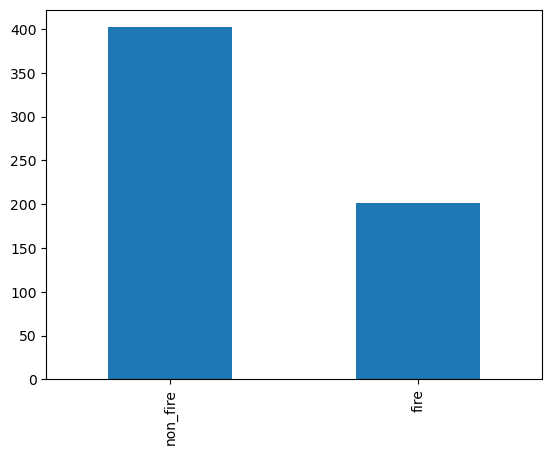

In [12]:
df['label'].value_counts().plot.bar()

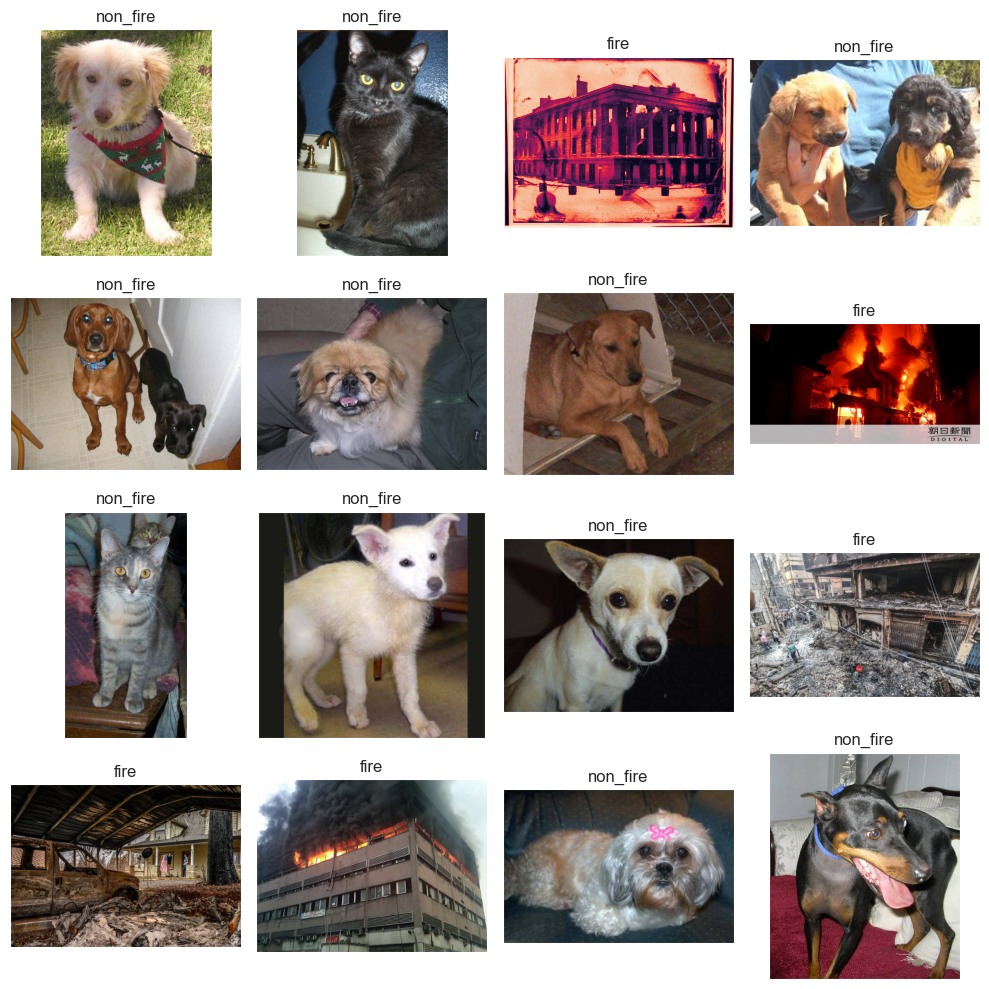

In [33]:
random_index = np.random.randint(0, len(df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(df.path[random_index[i]])
    ax.imshow(image)
    ax.set_title(df.label[random_index[i]])
plt.tight_layout()
plt.show()


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 61, 61, 64)       

In [56]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [45]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,)

In [46]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 483 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.


In [47]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)


{0: 'fire', 1: 'non_fire'}


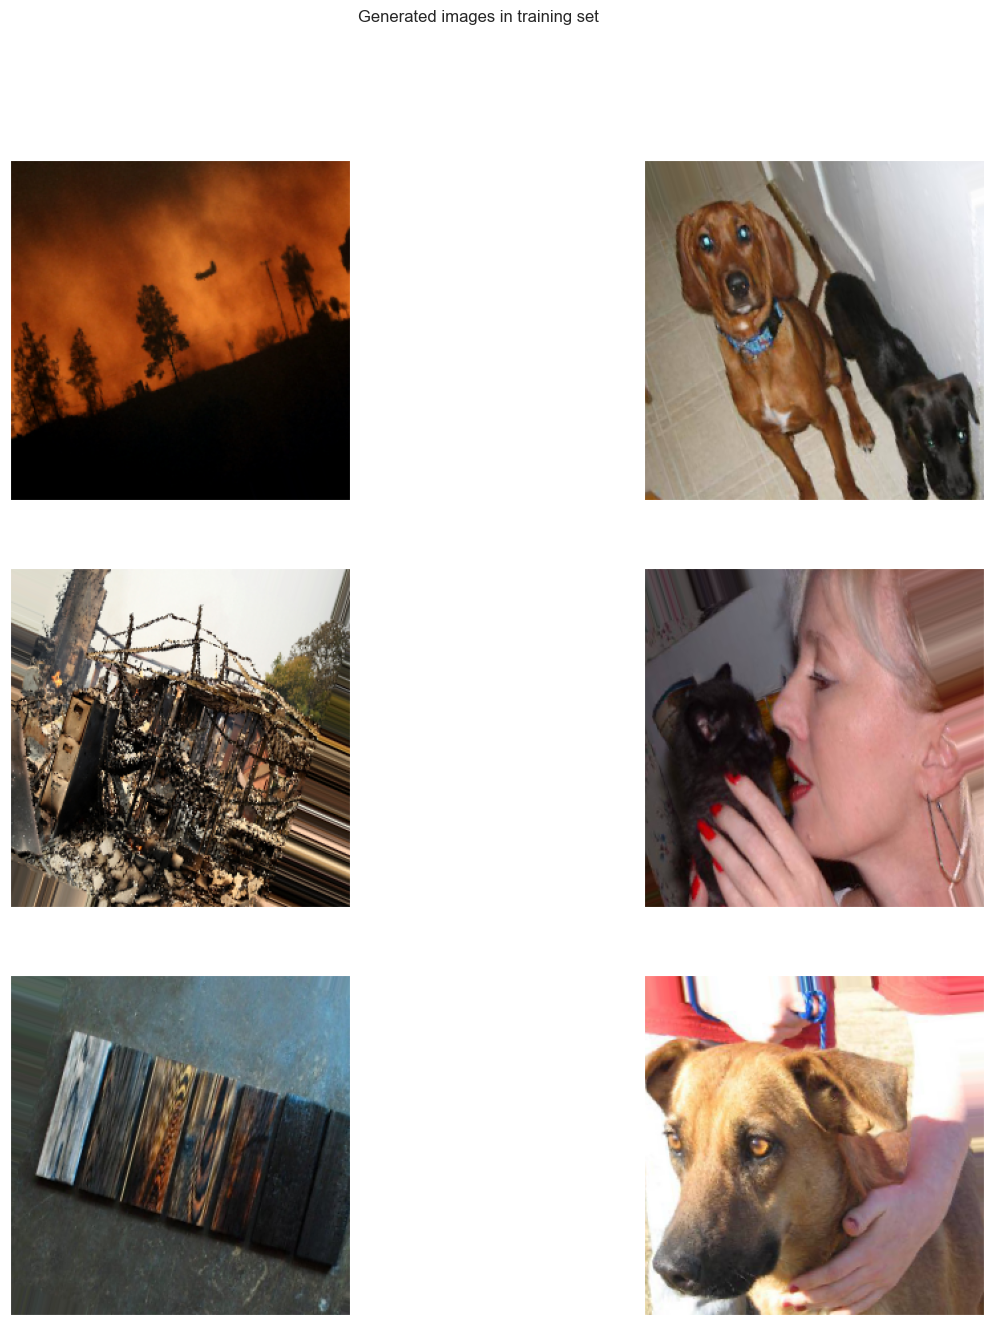

In [48]:
sns.set_style('dark')
pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [61]:
model.fit(x=train_gen,batch_size=32,epochs=15,validation_data=val_gen,callbacks=[earlystop,learning_rate_reduction])

Epoch 1/15
16/16 [==============================] - 93s 6s/step - loss: 0.8600 - accuracy: 0.6149 - val_loss: 0.6610 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 2/15
16/16 [==============================] - 85s 5s/step - loss: 0.5346 - accuracy: 0.7433 - val_loss: 0.5075 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/15
16/16 [==============================] - 95s 6s/step - loss: 0.3808 - accuracy: 0.8468 - val_loss: 0.4390 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 4/15
16/16 [==============================] - 88s 5s/step - loss: 0.4397 - accuracy: 0.8095 - val_loss: 0.3927 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 5/15
16/16 [==============================] - 88s 5s/step - loss: 0.3477 - accuracy: 0.8613 - val_loss: 0.5455 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/15
16/16 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8716
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 [==============================] - 87s 6s/step - loss: 0.33

In [76]:
test_image = image.load_img('C:/Users/amanr/Downloads/3.jpg',target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
train_gen.class_indices
if result[0][0] == 1:
    prediction = 'non_fire'
else:
    prediction = 'fire'

print(prediction)

1/1 [==============================] - 0s 169ms/step
fire


In [ ]:
img = cv2.imread('C:/Users/amanr/Downloads/3.jpg')
font = cv2.FONT_HERSHEY_SIMPLEX
text = 'Fire'
location = (10, 50)
font_scale = 1
font_color = (0, 0, 255)
line_type = 2
cv2.putText(img, text, location, font, font_scale, font_color, line_type)
cv2.imshow('fire',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()